# Lab 13: Serving Deep Learning Models

In this lab, we will learn how to serve a trained model. The goal of training a Machine Learning model is to use it to generate predictions. Deployment of Machine Learning models is a vast topic; we could write a whole book just about this topic. In this lab, we will present two ways of deploying a model and outline a set of things we need to consider for deployment. In the end, how will decide to deploy a model depends on the requirements that the application will have to satisfy and this will change case by case.

In this lab, we want to achieve a few goals. We want to explain at a high level how to think about the deployment process, highlighting the issues involved, and outlining the possible choices. This lab will help us understand the decision you'll need to make when deploying a model as well as equip you with a list of resources that you can tap into, according to your needs.

Then we will show you two ways of deploying a model: a simple [Flask application](http://flask.pocoo.org/) using a Python server and a more general deployment using [Tensorflow Serving](https://www.tensorflow.org/tfx/guide/serving). These are not the only two ways to deploy a model, and we'll make sure to point you to additional resources, companies, and products that simplify the management of the model deployment cycle.

So, let's start with the model development/deployment cycle.

## The model development cycle

The concepts explained in this part are general to Machine Learning, not just Deep Learning, and they are independent of the framework used. At a high level, the model development cycle includes these seven steps:

1. Data Collection
2. Data Processing
3. Model Development
4. Model Evaluation
5. Model Exporting
6. Model Deployment
7. Model Monitoring

These steps are part of a continuous deployment cycle: we never finish to improve our models and to learn from new data. After deploying our first model, a second, a third, and more will come. For each new model, we compare its performance with the performance of the current one. Traffic will gradually be shifted towards the new model, as it happens with any other release in a continuous integration setup.

The seven steps are not mutually exclusive. They happen in parallel. In other words, while you are working on developing (3) and evaluating (4) the current version of a model,  you are already monitoring the previous version of the model (7) and collecting (1) and processing (2) additional data and labels.

![Model deployment cycle](./assets/deploy_cycle.png)

Let's now look at each step in greater detail.

### Data Collection

Throughout this labs, we used datasets based on files. These were either tabular files (CSV, Excel) or folders containing images or documents. In the real world, there is usually a process involving data collection, where data is stored in a database or a distributed file system for later use.

Examples of this process are:

- a database with the actions of your users in your website or app
- a data-lake with millions of documents that we would like to classify
- a cloud object store with images that we would like to recognize

Depending on the type of data, on its frequency and its size, you will design different collection and storage systems.

Let's consider a few examples.

As a first case let's consider a bank that would like to train a model to decide which people are credit-worthy. The information used as input for the model are things like:

- user information
- account activity
- past loans
- history of credit

This information will typically be stored in several tables in a database. We will be able to create a dataset to train our model by simply joining data from a few tables of the database. Furthermore, we can probably work with a sample of the whole data as a starting point, especially if our first model is not specific to each user. This "snapshot" of the world, a dataset we extracted at some point in time, is going to be valid for at least a few days, if not for a few weeks or even months. That is to say, the general lending behavior of a population will evolve with time, but it will do so quite slowly, not from one day to the next. Another way to say this is to say that the statistical distribution of our users is stationary, or quasi-stationary, i.e., independent from time.

These facts allow us to train a model on a file, maybe a large file, but a fixed snapshot, as we did throughout this labs, and then use that model in production. Once we have trained and evaluated our model, we will deploy it to our branches and the managers will have an "AI helper" to decide when to issue a loan or not.

Let's consider a very different case now. Let's say we want to build a system that will decide which advertisement to show based on the actions of a user in our web application. In this case, the input will be a series of events in the app. Both the app and the ads inventory will change much more frequently in time, due to new feature releases, new clients and so on. In this case, we will re-train our model much more regularly, possibly every day, using the most recent data.

Besides the frequency of re-training, other things to consider are:

- the kind of data, are these files, documents, images, text, numbers in a table?
- the amount of data, how many new data points do we collect per day? 100? 1000? 1 million? 1 billion? The data collection and storage process will change dramatically based on that.

Modern Machine Learning products usually work as a continuous pipeline, where a model is continuously learning from new data, and sometimes a snapshot of the most current model is saved and used in production for inference.

### Labels

As we know very well by now, to train a model with supervision, we need labels. Here too, there can be many different scenarios.

In some cases, we may not have those labels at all. For example, let's say we are training an algorithm to recognize offensive pictures in our user-generated content. We will need to collect a sample of images and have human supervisors manually label the offensive photos with labels such as "violence", "nudity", "toxic" and so on. This labeling process will be slow and costly, but it will be necessary before we can proceed with any training.

Additionally, if we randomly sample our images, there will likely be very few offensive images, which would make labeling very slow because our human supervisors would receive mostly normal pictures. This is why most websites implement a button for users to report offensive content. This will effectively triage the photos bringing the offensive ones to the surface so that human supervisors can review them and generate labels accordingly.

On the opposite end, if we are training a model for advertising products, i.e., to predict the likelihood that a user will click on a particular product, the labels, i.e., the past clicks, are automatically recorded by our system.

In general, the win-win strategy for label generation is when the product manager can design a product in such a way that the users or the process automatically generate labels. Examples of this win-win approach are:

- tagging your friends on Facebook  => labels for face recognition algorithm
- recording purchase actions on Amazon => labels for the recommendation of other products
- "flag this post" button on Craigslist => labels for fraud/spam detection algorithm
- captchas that ask you to recognize street signs => labels for image recognition algorithm

What is the process for label generation in your case?

### Data Processing

This process is usually referred to as ETL in an enterprise setting. It involves going from the raw data in your data store to features ready for consumption by the Machine Learning model.

At this stage, you will focus on operations like data cleaning, data imputation, feature extraction, and feature engineering. Once again, this will depend on your specific situation, but it is essential to keep in mind that when NULL values are present, i.e., when some data is missing, we need to stop and ask ourselves why it is missing. Discussion of the different cases of missing data is beyond the scope of this labs, but we invite you to read this [Wikipedia article on the topic](https://en.wikipedia.org/wiki/Missing_data), to be cognizant of the issues involved when dealing with it.

Other data processing steps may involve generating features, augmenting the data, one-hot encoding, using pre-trained models for feature extraction.

### Model Development

Model development and data processing are strongly interconnected steps. Here is where we focus the attention on deciding which model we will apply.

- Will you attempt with a classical Machine Learning model first?
- Will you go straight to Neural Networks and Deep Learning?
- What will your model architecture look like?
- Which hyper-parameters will you start with?
- Are you going to train the model with gradient descent?
- If so, which optimizer will you use?

Again, the choices will depend on the particular situation. The general approach to this phase is to **keep your feedback loop as rapid as possible**. It's not a mystery that a quick feedback loop is an excellent strategy in software development (e.g., Agile development). In Machine Learning this is just as true, so if you are considering two options to improve your model and one takes one hour to test, and the other one week, you should choose the former over the latter.

Let's look at one example. Let's say that we have some indication our model will improve with more data. Let's also suppose that we are not sure that we have chosen the right architecture for the model. In some cases, getting more data could be as simple as running a new SQL query to extract a few more million data points from our database, in some other cases it could be much more complicated, involving manual label generation with a team of supervisors, which would likely require days if not weeks of delay.

On the other hand, if re-training the model takes minutes or even just a few hours we could spin up a new copy of the model with a different architecture and train it quickly. If training the model takes one week that's not an easy option.

We will have to take all these factors into account when developing the model and choosing where to start first.

### Model Evaluation

Once we have decided what model architecture we are going to use, we need to train the model on the data. The majority of this labs focuses on this process, so you should be pretty familiar with terms like train/test splitting, cross-validation, and hyper-parameter tuning. It is important that at this stage you know what baseline you measure against and what metric you are going to use. If this is your first model attempt, you are probably comparing the performance with a dummy model (i.e., one that always predicts the average label or the majority class). On the other hand, if you have previously deployed other models, you will compare the model performance with that of the previous model.

You will have to consider what overall goal you are trying to achieve. In the case of a binary classification problem, you will consider metrics like precision and recall to evaluate if your model has lots of false positives or false negatives. The choice you make will depend on your business goal and your data. For example, if you are deploying a model that predicts patient sickness you will try to avoid false negatives because you wouldn't want to leave any screened patient with a false impression that they are healthy when they are are not. On the other hand, if you are developing a system for flagging spam, you will focus more on avoiding false positives, which would route legitimate emails to the spam folder, creating a bad user experience.

In summary, you will need to decide:

- the metric you are trying to optimize
- the baseline for that metric
- what a significant improvement over the baseline is
- the kind of errors you would like to minimize

These considerations will guide you in during the training process.

If you plan to do hyper-parameter training,  you must split your total dataset into three parts:

- training
- validation
- test

The **training** data will be used to train the model. The **validation** data will serve as "test" data for hyper-parameter tuning. I.e., for each new combination of hyper-parameters you will train the model on the training portion and validate the model on the validation portion. This split is like having two nested training loops. The inner training loop will choose the weights and biases of your network. The outer training loop will choose the hyper-parameters like learning rate, batch size, and the number of layers.

None of these models will see the test set until the end. Once you have chosen the best hyper-parameters and you have trained the best model on that data, only then, you will test your trained model on the **test** set to get a sense of how well your model is going to perform with out-of-sample data, i.e., an indication of how well your model is going to do when deployed.

### Model Exporting

After training and evaluating the model, it is time to prepare it for serving predictions. What happens at this stage will depend on many requirements including desired latency, footprint, the device you are planning to use for serving and many more.

At one end of the spectrum, this steps is as simple as saving the trained model to disk as is. The trained model is composed of 2 parts, the model architecture, and the trained weights. This method is perfect when we use Keras to build our model and plan to serve it as part of a Python/Flask application. It is not optimized at all, but if all we care is to build a proof of concept and if we don't need to support high traffic then this can be fast to execute. This is the first method we will explore in this lab.

On the other end of the spectrum are large scale deployments. If we are planning to use our model in a high availability production environment, we need to optimize it for serving predictions within the constraints required by our application.

For example, if we plan to use a model to make real-time decisions on serving ads or recommending products, we will have very stringent latency specifications, usually a few tens of milliseconds at most. This requirement will influence the choices we make when designing the model as well as when saving it.

The topic of model optimization is vast, and it requires tools that go beyond the scope of this labs. We will, therefore, limit ourselves to pointing out what kind of optimizations are possible and where to look for information about them.

Model optimization techniques may involve:

- stripping away all operations not needed for inference. The Tensorflow graph underlying our Keras model still contains all the training-related ops, including the gradients calculations and the optimizer. None of these are relevant at inference time, and we should strip them away from the graph. Tensorflow has a [Graph Transform Tool](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/tools/graph_transforms/README.md) that includes many options to check out. Common cases covered by the tool are:

    - Optimizing for Deployment
    - Fixing Missing Kernel Errors on Mobile
    - Shrinking File Size
    - Eight-bit Calculations

- low-level compilation of tensorflow operations using the [Accelerated Linear Algebra compiler (XLA)](https://www.tensorflow.org/xla/). This compiler optimizes operations for the specific platform used for deployment, and it can help in the following areas:

    - Improve execution speed
    - Improve memory usage
    - Reduce reliance on custom Ops
    - Reduce mobile footprint
    - Improve portability

In addition to model optimization, we can improve inference performance by choosing the hardware platform that is most adapt to our model. Currently, Tensorflow supports CPU, GPU, and TPU training and inference. In the coming years, we'll see a flourishing of hardware platforms dedicated to Deep Learning model training and serving, which will bring additional options to the table.

In this lab, we'll see how to save a Keras model in Tensorflow format, so that all the above tools can be applied.

### Model Deployment

Model deployment refers to how we are going to make our model available to the rest of the world. In several cases, this is a Python/Flask application that loads the model to memory and then runs `model.predict` when requested. This is the first method we will explore in this lab. It's is a great way to deploy a proof of concept in situations where we do not need high throughput.

The natural extension of this method is to containerize the Flask app with Docker so that we can replicate the model multiple times and adjust our model to the load requested by our application. While this works, it is not the recommended solution when scaling out operations. Tensorflow offers a server which is the preferred way to deploy models at scale. Tensorflow 2.0 includes [Tensorflow Extended (TFX)](https://www.tensorflow.org/tfx) which covers all the steps in the deployment cycle.

That's why in this lab we will also go through a minimal deployment with Tensorflow Serving. Tensorflow Serving is a powerful package developed with large deployments in mind. We will introduce it and guide you to more resources if you need to scale out operations with your models.

More generally, we deploy a new model in parallel to an existing model we validate its performance with live traffic in a classic A/B test scenario. Here traffic is only partially routed to the new model, and its performance is monitored against for some time before completely adopting it and phasing out the old one.

This strategy is why deployment must also include monitoring of the model performance.

### Model Monitoring

Last but not least, when we deploy a model we want to monitor its performance. It is important to sample the predictions of the model and send a few of them to human supervision to verify their quality. In other words, label collection never ends. We need to keep measuring the performance of our model against a known set of labels.

In some cases, this process is automated, for example, the case where our model predicts future values of a time series, e.g., the price of a stock for trading purposes. In this case, as soon as we get the next number in the time series, we can immediately compare it with the prediction from our model and monitor its quality in real-time.

In other cases, where human supervisors generate labels, we need to keep sending data to a QA team that will label them. We can then compare the predictions with the labels and decide how to improve the model on the cases where it failed.

This process never ends; we can always come up with better models. However, we should not be discouraged by this.  As British mathematician [George E. P. Box](https://en.wikipedia.org/wiki/George_E._P._Box) said: ["All models are wrong; some models are useful"](https://en.wikipedia.org/wiki/All_models_are_wrong). You can reap enormous benefits from a model that is not perfect.

Let's deploy our first model. We will build an API that can predict the location of a user based on the strength of WiFi signals detected.

## Deploy a model to predict indoor location

As an example of deployment we will develop an app that can determine the indoor location of a user based on the WiFi signal strength observed on smartphone. Data comes from [the UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Wireless+Indoor+Localization) and it is made available to you in [data/wifi_location.csv](../data/wifi_location.csv). We will quickly load and train a model and then focus on exporting this model to build an API that can predict the location of a user based on the WiFi signal strength.

### Data exploration

Let's start by loading the usual packages:

In [1]:
with open('common.py') as fin:
    exec(fin.read())

In [2]:
with open('matplotlibconf.py') as fin:
    exec(fin.read())

And let's load the data with Pandas:

In [3]:
df = pd.read_csv('../data/wifi_location.csv')

Let's quickly inspect the data to get a sense for what we have:

In [4]:
df.head()

,a_1,a_2,a_3,a_4,a_5,a_6,a_7,location
0,-64,-56,-61,-66,-71,-82,-81,0
1,-68,-57,-61,-65,-71,-85,-85,0
2,-63,-60,-60,-67,-76,-85,-84,0
3,-61,-60,-68,-62,-77,-90,-80,0
4,-63,-65,-60,-63,-77,-81,-87,0


It looks like we have 7 features, presumably the strengths of the wifi signals coming from 7 different access points. There's also a column called `location` that will be our label. Let's see how many locations there are in the dataset:

In [5]:
df['location'].value_counts()

3    500
2    500
1    500
0    500
Name: location, dtype: int64

Great! The dataset is balanced and it has 500 examples of each location! Since we have only 2000 points total, we can plot the features and take a look at them:

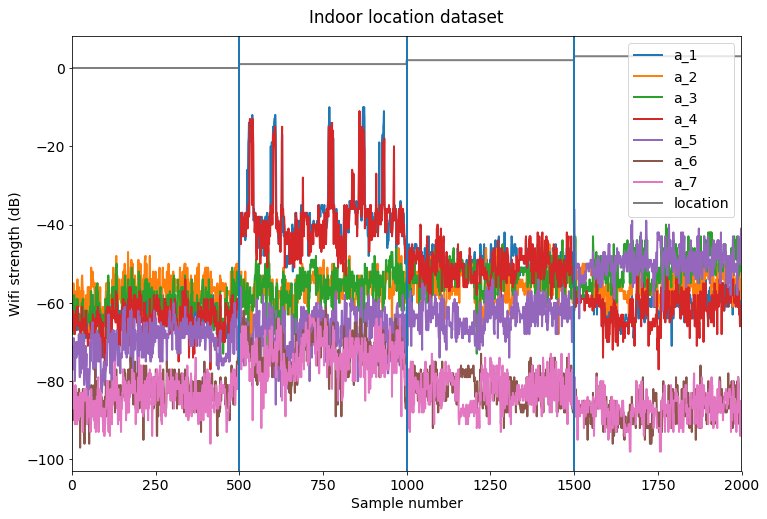

In [6]:
df.plot(figsize=(12, 8))
plt.axvline(500)
plt.axvline(1000)
plt.axvline(1500)
plt.title('Indoor location dataset')
plt.xlabel('Sample number')
plt.ylabel('Wifi strength (dB)');

From the plot we can clearly see that the wifi signal strengths are different in the 4 locations and therefore we can hope to be able to be able to predict the location of a person based on these features. To further remark this point, let's do a pairplot using Seaborn and let's color the data by location:

In [7]:
import seaborn as sns

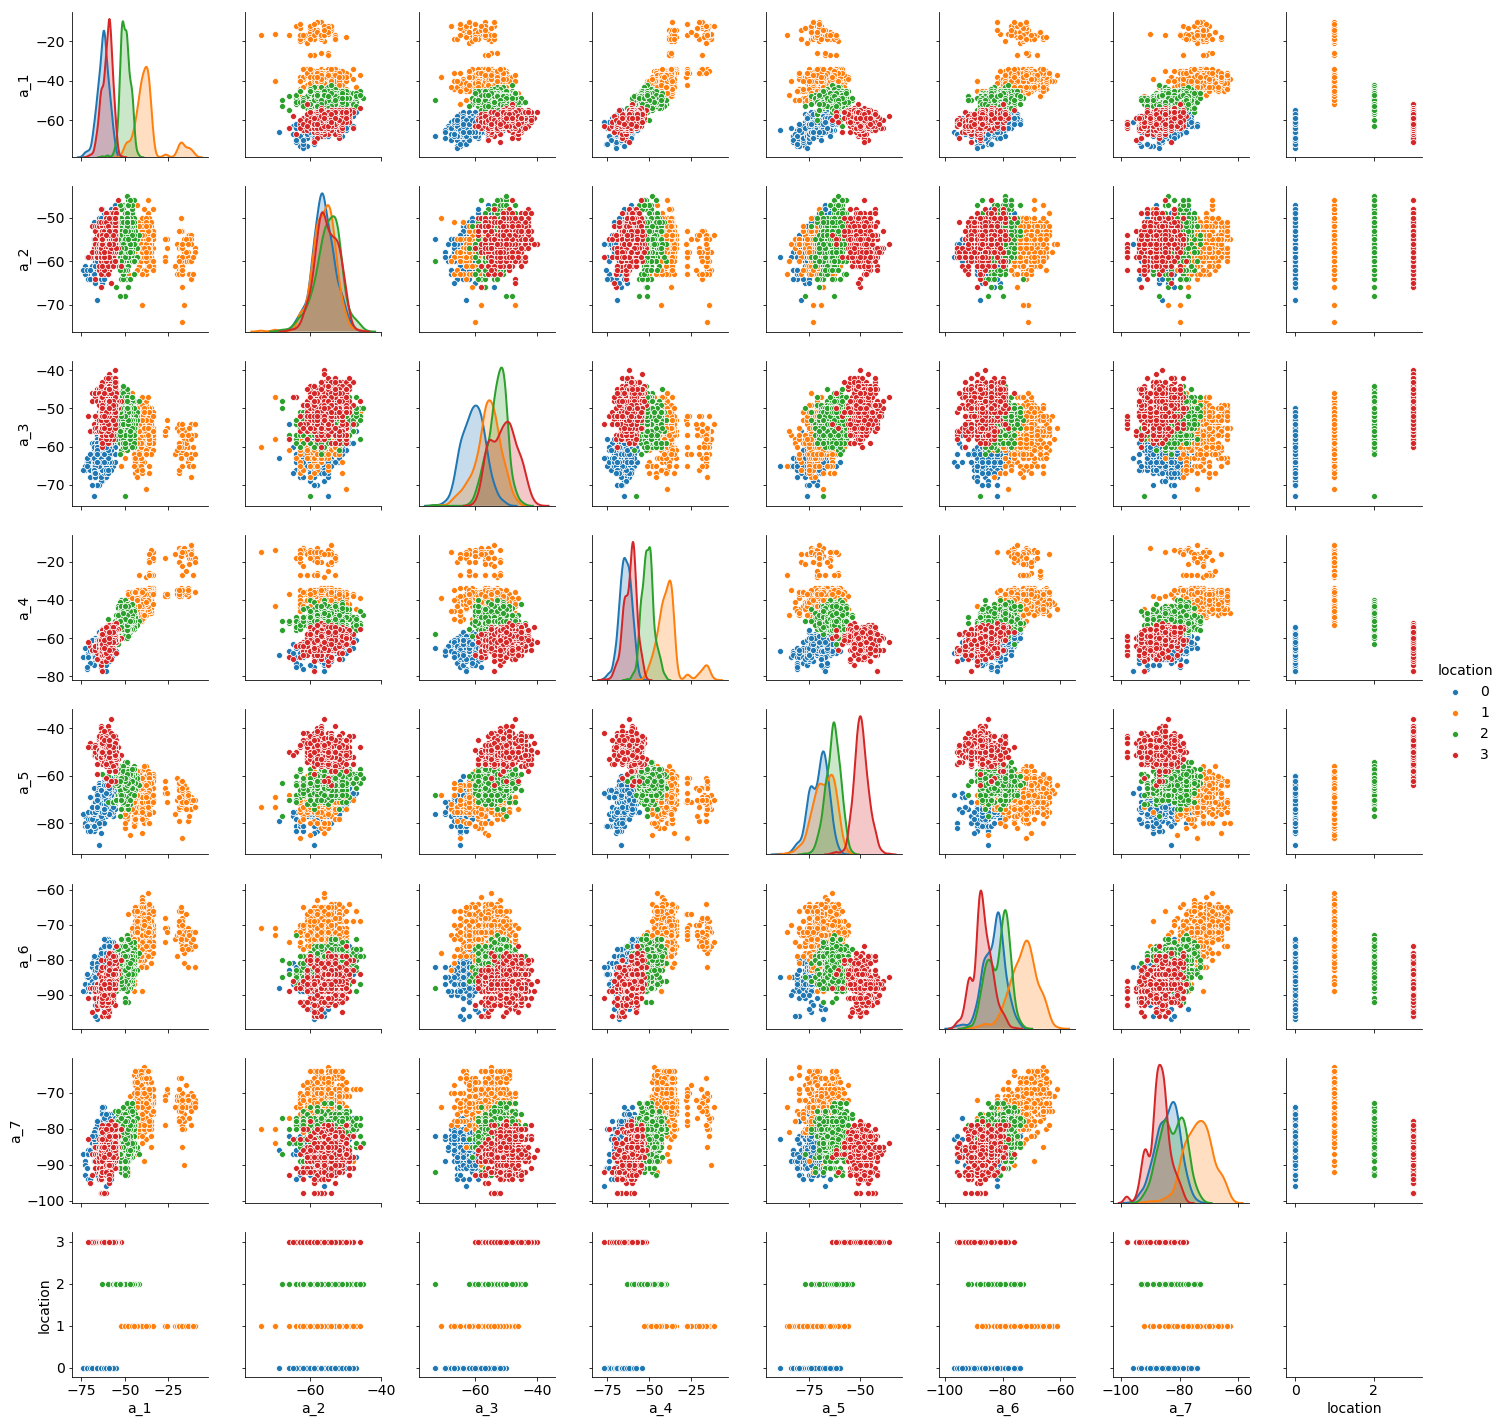

In [8]:
sns.pairplot(df, hue='location');

### Model definintion and training

It is very clear that the 4 locations are quite well defined and therefore we can hope to train a good model. Let's do that! First let's define our usual `X` and `y` arrays of features and labels:

In [9]:
X = df.drop('location', axis=1).values
y = df['location'].values

Then we'll split our data into training and test, using a 25% test split.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25,
                     random_state=0)

Now let's build a fully connected model using the [Functional API in Keras](https://keras.io/getting-started/functional-api-guide/). Let's import the Model class as well as a few layers:

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import BatchNormalization

In particular notice that we'll use the `BatchNormalization` layer right after the input, since our features take negative large numbers, which may slow the convergence of our model. Let's build a fully connected model with the following architecture:

- Input
- Batch Normalization
- Fully connected inner layer with 50 nodes and a ReLU activation
- Fully connected inner layer with 30 nodes and a ReLU activation
- Fully connected inner layer with 10 nodes and a ReLU activation
- Output layer with 4 nodes and a Softmax activation

The functional API makes it very easy to build this model:

In [13]:
inputs = Input(shape=X_train.shape[1:])
x = BatchNormalization()(inputs)
x = Dense(50, activation='relu')(x)
x = Dense(30, activation='relu')(x)
x = Dense(10, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

Let's display a model summary and make sure that we have built exactly what we wanted:

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 7)                 28        
_________________________________________________________________
dense (Dense)                (None, 50)                400       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 44        
Total params: 2,312
Trainable params: 2,298
Non-trainable params: 14
__________________________________________________________

Great! Now we can compile the model. Notice that since our labels are not one-hot encoded we should use the `sparse_categorical_crossentropy` instead of the usual `categorical_crossentropy`:

In [15]:
model.compile('adam',
              'sparse_categorical_crossentropy',
              metrics=['accuracy'])

We are now ready to train the model. Let's train it for 40 epochs, using the test data to validate the performance:

In [16]:
h = model.fit(X_train, y_train,
              batch_size=128,
              epochs=40,
              verbose=0,
              validation_data=(X_test, y_test))

As we have done several times in the labs, we can display the history of training leveraging Pandas plotting capabilities:

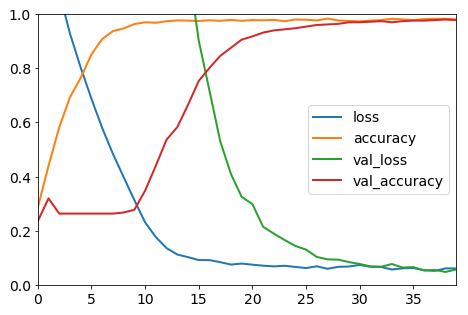

In [17]:
pd.DataFrame(h.history).plot()
plt.ylim(0, 1);

The training graph looks very good. The model has converged to almost perfect accuracy and there is no sign of overfitting. This is great! We are ready to export the model for deployment.

### Export the model with Keras

Tensorflow offers several ways to export a model. The simplest way is to save the model architecture and the weights as separate compressed file using the `model.save_weights` method. This saves the model in a framework-agnostic format where the model structure is specified as a json file and the weights are saved as an array. We can import a model saved in this way into other frameworks that are not necessarily Keras. You can read more about the various ways of saving a model [here](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model). Let's start by importing the [`os`](https://docs.python.org/3/library/os.html), [`json`](https://docs.python.org/3/library/json.html) and [`shutil`](https://docs.python.org/3/library/shutil.html) packages:

In [18]:
import os  # Miscellaneous operating system interfaces
import json  # JSON encoder and decoder
import shutil  # High-level file operations

Next we define the output path to save our model. This path will be composed of three parts:

- a base path, in this case it's going to be `/tmp/ztdl_models/wifi/`
- a subpath, referring to the type of deployment system we'd like to use, here: `/flask`
- a version number, starting from 1. We use this in case we'd like to deploy a new version of the model later on.

In [19]:
base_path = '/tmp/ztdl_models/wifi'
sub_path = 'flask'
version = 1

Let's combine these in a single path using [`join`](https://docs.python.org/3/library/os.path.html#join):

In [20]:
from os.path import join

In [21]:
export_path = join(base_path, sub_path, str(version))
export_path

'/tmp/ztdl_models/wifi/flask/1'

Next we create the export path. We delete it first and then re-create it as an empty path:

In [22]:
shutil.rmtree(export_path, ignore_errors=True)  # delete path, if exists
os.makedirs(export_path)  # create path

Now we are ready to save the model. Let's have a look at the json description of the model:

In [23]:
json.loads(model.to_json())

{'class_name': 'Model',
 'config': {'name': 'model',
  'layers': [{'name': 'input_1',
    'class_name': 'InputLayer',
    'config': {'batch_input_shape': [None, 7],
     'dtype': 'float32',
     'sparse': False,
     'name': 'input_1'},
    'inbound_nodes': []},
   {'name': 'batch_normalization_v2',
    'class_name': 'BatchNormalizationV2',
    'config': {'name': 'batch_normalization_v2',
     'trainable': True,
     'dtype': 'float32',
     'axis': [1],
     'momentum': 0.99,
     'epsilon': 0.001,
     'center': True,
     'scale': True,
     'beta_initializer': {'class_name': 'Zeros', 'config': {}},
     'gamma_initializer': {'class_name': 'Ones', 'config': {}},
     'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}},
     'moving_variance_initializer': {'class_name': 'Ones', 'config': {}},
     'beta_regularizer': None,
     'gamma_regularizer': None,
     'beta_constraint': None,
     'gamma_constraint': None},
    'inbound_nodes': [['input_1', 0, 0, {}]]},
   {'name

Nice! The whole model is specified in a few lines! To save it we'll open a `model.json` file and then write to it the json version of the file:

In [24]:
with open(join(export_path, 'model.json'), 'w') as fout:
    fout.write(model.to_json())

Next we save the weights. We do this with the `.save_weights` method of the model:

In [25]:
model.save_weights(join(export_path, 'weights.h5'))

Let's check the content of the `export_path` using the the `os.listdir` command:

In [26]:
os.listdir(export_path, )

['model.json', 'weights.h5']

As you can see there are 2 files, the json description of the model and the weights. Great! Let's see how one would re-load these into a new model. First we need to import the `model_from_json` function:

In [27]:
from tensorflow.keras.models import model_from_json

Next we create a model by reading the json file:

In [28]:
with open(join(export_path, 'model.json')) as fin:
    loaded_model = model_from_json(fin.read())

The loaded model has random weights, as we can verify by generating predictions on the test set and then comparing them with the labels. Notice that since the model was defined using the functional API, there is no `.predict_classes` method. Let's use the `.predict` method to obtain the probabilities for each class:

In [29]:
probas = loaded_model.predict(X_test)
probas

array([[1.9623779e-03, 4.2173272e-01, 5.7627738e-01, 2.7486160e-05],
       [2.0370120e-03, 4.1319522e-01, 5.8476287e-01, 4.8723236e-06],
       [1.7021670e-03, 3.8001499e-01, 6.1827278e-01, 1.0041487e-05],
       ...,
       [2.2756129e-03, 5.1100945e-01, 4.8667276e-01, 4.2136431e-05],
       [3.2322973e-04, 7.9969421e-02, 9.1968787e-01, 1.9512345e-05],
       [2.2151337e-03, 9.3508476e-01, 6.2669002e-02, 3.1056396e-05]],
      dtype=float32)

To retrieve the predicted classes we need to use the `argmax` function from Numpy:

In [30]:
preds = np.argmax(probas, axis=1)
preds

array([2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2,
       1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 2,
       2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1,
       2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1,
       2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1,

Finally we can check the accuracy of these prediction using the `accuracy_score` from Scikit-Learn:

In [31]:
from sklearn.metrics import accuracy_score

In [32]:
accuracy_score(y_test, preds)

0.132

As expected, this model is not trained. Let's load the weights now:

In [33]:
loaded_model.load_weights(join(export_path, 'weights.h5'))

And let's repeat the steps above:

In [34]:
probas = loaded_model.predict(X_test)  # class probabilities
preds = np.argmax(probas, axis=1)  # class prediction
accuracy_score(y_test, preds)  # accuracy score

0.976

Great! The model is now using the trained weights, so we can use it for inference in deployment.

Notice that this model is not trainable. If you tried to run the command:

```python
loaded_model.fit(X_train, y_train)
```

You would get a `RuntimeError` like this one:

```python
RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.
```

As the message explains, to train the model we need to compile it first, i.e., add to the graph all the operations concerning gradient calculation, loss calculation, and optimizer. We don't need any of this for deployment, so let's not compile the model.

## A simple deployment with Flask

> **WARNING**: The simple script we run here is not for production use. Please make sure to read how to deploy a Flask app to production in the [Flask documentation](http://flask.pocoo.org/docs/1.0/tutorial/deploy/).

As the documentation says, [Flask](http://flask.pocoo.org/) is a microframework for Python based on Werkzeug, Jinja 2, and good intentions. Also, before you ask: It's BSD licensed!

It's a popular choice for simple websites, APIs, and in general web development. We'll use it here to load our model in a simple application that will launch from a script.

We will here go through the commands that compose the script and tell you how to run it from the shell. Let's get started.


> TIP: if you have installed the most recent version of our `ztdlbook` environment file, you should already have Flask installed. Otherwise, go back to [Lab 1](./01_Getting_Started.ipynb#Conda-Environment) and check the instructions on how to create or update the environment.


The script will first import the `Flask` and `request` classes. `Flask` is the main app, while  `request` will be used to collect the data received by the app.

In [35]:
from flask import Flask
from flask import request

We also import `tensorflow` which we'll need when loading the model:

In [36]:
import tensorflow as tf

Then we define a global variable for the model and its export path.

In [37]:
export_path = '/tmp/ztdl_models/wifi/flask/1/'
loaded_model = None

Next we create the flask app, which is also a global variable:

In [38]:
app = Flask(__name__)

The next step is to define a `load_model` function that loads the model from the `export_path` like we did before:

In [39]:
def load_model():
    """
    Load model and tensorflow graph
    into global variables.
    """
    
    # global variable
    global loaded_model

    # load model architecture from json
    with open(join(export_path, 'model.json')) as fin:
        loaded_model = model_from_json(fin.read())

    # load weights
    loaded_model.load_weights(join(export_path, 'weights.h5'))
    print("Model loaded.")

The second function we define is a `preprocess` function that can be used to perform any normalization, feature engineering or other preprocessing. In the current scenario we use this function to convert the data from json to a Numpy array.

In [40]:
def preprocess(data):
    """
    Generic function for normalization 
    and feature engineering.
    Convert data from json to numpy array.
    """
    res = json.loads(data)
    return np.array(res['data'])

Next we define a function called `predict`, which performs the following operations:

- take the data from `request.data`
- preprocess the data with the `preprocess` function
- use the loaded model to predict probabilities
- extract the predicted classes from probabilities using `np.argmax`
- return a json version of the predictions

Notice that we will "decorate" this function with the decorator:

```python
@app.route('/', methods=["POST"])
```

This method tells Flask that this function should be called when a POST request is received at the `/` route. For more information on how this is done in flask please make sure to check the [extensive documentation](http://flask.pocoo.org/docs/1.0/quickstart/#a-minimal-application).

In [41]:
@app.route('/', methods=["POST"])
def predict():
    """
    Generate predictions with the model
    when receiving data as a POST request
    """
    if request.method == "POST":
        # get data from the request
        data = request.data
        
        # preprocess the data
        processed = preprocess(data)

        # run predictions
        probas = loaded_model.predict(processed)
        
        # obtain predicted classes from probabilities
        preds = np.argmax(probas, axis=1)
        
        # print in backend
        print("Received data:", data)
        print("Predicted labels:", preds)

        return jsonify(preds.tolist())

Finally we complete the script with an if statement that runs the app in debug mode:

```python
if __name__ == "__main__":
    print("* Loading model and starting Flask server...")
    load_model()
    app.run(host='0.0.0.0', debug=True)
```

Please note that this is not the preferred mode to run a flask app. Please refer to the [documentation](http://flask.pocoo.org/docs/1.0/quickstart/) for more information.

### Full script

Let's take a look at the whole script using the `cat` shell command.

> TIP: if this doesn't work on your system, simply open the script in your favorite text editor:

In [42]:
!cat 13_flask_serve_model.py
#!pygmentize -O style=monokai -g 13_flask_serve_model.py

import os
import json
import numpy as np
from tensorflow.keras.models import model_from_json

from flask import Flask
from flask import request, jsonify
import tensorflow as tf

loaded_model = None

app = Flask(__name__)


def load_model(export_path):
    """
    Load model and tensorflow graph
    into global variables.
    """

    # global variable
    global loaded_model

    # load model architecture from json
    with open(os.path.join(export_path, 'model.json')) as fin:
        loaded_model = model_from_json(fin.read())

    # load weights
    loaded_model.load_weights(os.path.join(export_path, 'weights.h5'))

    print("Model loaded.")


def preprocess(data):
    """
    Generic function for normalization
    and feature engineering.
    Convert data from json to numpy array.
    """
    res = json.loads(data)
    return np.array(res['data'])


@app.route('/', methods=["POST"])
def predict():
    """
    Generate predictions with the model
    when receiving data as a POST requ

### Run the script

We can run this script from the `course` folder as:

```
python 13_flask_serve_model.py
```

Make sure to check [Flask Documentation](http://flask.pocoo.org/docs/1.0/quickstart/#a-minimal-application) if you encounter any issues with the above steps.

You should see the following output:

```
Using TensorFlow backend.
* Loading model and starting Flask server...
2018-06-18 11:34:31.339142: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Model loaded.
 * Serving Flask app "13_flask_serve_model" (lazy loading)
 * Environment: development
 * Debug mode: on
 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)
 * Restarting with stat
Using TensorFlow backend.
* Loading model and starting Flask server...
2018-06-18 11:37:57.101110: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Model loaded.
 * Debugger is active!
 * Debugger PIN: xxx-xxx-xxx
```

### Get Predictions from the API

Now that the server is running, let's send some data to it and get predictions. We can test the application with a simple CURL request like:

```
curl -d '{"data": [[-62, -58, -59, -59, -67, -80, -77],
                   [-49, -53, -50, -48, -67, -78, -88],
                   [-52, -57, -49, -50, -66, -80, -80]]}' \
     -H "Content-Type: application/json" \
     -X POST http://localhost:5000
```

Which should return:

```
[
  0,
  2,
  2
]
```

What did we do? We have sent the wifi signal detected by three mobile phones and obtained their location. The first one is in zone 0, and the other two are in zone 2. Great!

We can also ping our API using Python from the notebook by importing the `requests` module:

In [43]:
import requests

We set the `api_url` variable:

In [44]:
api_url = "http://localhost:5000/"

Get a few points from the test dataset:

In [45]:
data = X_test[:5].tolist()

In [46]:
data

[[-62, -58, -59, -59, -67, -80, -77],
 [-49, -53, -50, -48, -67, -78, -88],
 [-52, -57, -49, -50, -66, -80, -80],
 [-40, -55, -52, -43, -60, -76, -72],
 [-64, -59, -51, -67, -43, -88, -92]]

Create `payload` and `headers` dictionaries:

In [47]:
payload = {'data': data}
headers = {'content-type': 'application/json'}

Finally send a post request to the `api_url` with a our data in json format. We collect the request response into a `response variable`:

In [48]:
response = requests.post(api_url,
                         data=json.dumps(payload),
                         headers=headers)

Let's check the response:

In [49]:
response

<Response [200]>

If you see: `<Response [200]>` it means the request worked. Let's check the response we obtained:

In [50]:
response.json()

[0, 2, 2, 1, 3]

We can compare that with our labels:

In [51]:
y_test[:5]

array([0, 2, 2, 1, 3])

The deployed model is working pretty well! Very nice! There are many options to host your deployed model, including:
- hosting the Flask app on [AWS](https://aws.amazon.com/), [GCloud](https://cloud.google.com/training/), [Azure](https://azure.microsoft.com/)
- deploying it on [Heroku](https://www.heroku.com/)
- deploying it on [Floydhub](https://www.floydhub.com/)

Now go ahead and amaze your friends!

This lab continues introducing a different way to export and deploy a model, which leverages [Tensorflow Serving](https://www.tensorflow.org/tfx/guide/serving). This is the preferred way for larger production deployments.

## Deployment with Tensorflow Serving

As the [documentation](https://www.tensorflow.org/tfx/guide/serving) says, TensorFlow Serving is a flexible, high-performance serving system for Machine Learning models, designed for production environments. TensorFlow Serving makes it easy to deploy new algorithms and experiments while keeping the same server architecture and APIs. TensorFlow Serving provides out-of-the-box integration with TensorFlow models but can be easily extended to serve other types of models and data.

Tensorflow Serving can accommodate both small and large deployments, and it is ready for production. It used to be difficult to use but, with the recent release of Tensorflow 2.0, it got greatly simplified. If you are serious about using it, we recommend you take a look at the [Architecture overview](https://www.tensorflow.org/tfx/guide/servingarchitecture_overview) that explains many concepts like Servables, Managers, and Sources.

In this part of the labs, we will just show you how to export a model for serving and how to ping a Tensorflow serving server using both the REST and the gRPC interfaces.

### Saving a model for Tensorflow Serving

Let's get started by exporting the model for Tensorflow Serving. Let's start by defining an export path:

In [52]:
base_path = '/tmp/ztdl_models/wifi'
sub_path = 'tfserving'
version = 1

Notice that we can bump up the version number if we save a new model later on. Like before, we can combine these:

In [53]:
export_path = join(base_path, sub_path, str(version))
export_path

'/tmp/ztdl_models/wifi/tfserving/1'

Let's clear the `export_path` in case it already exists:

In [54]:
shutil.rmtree(export_path, ignore_errors=True)

Saving a Tensorflow model for serving used to be quite complicated. However, Tensorflow 2.0 makes it as easy as calling the `tf.saved_model.save` function. Let's do it:

In [55]:
tf.saved_model.save(model, export_path)

Now let's check what's been saved:

In [56]:
os.listdir(export_path)

['assets', 'saved_model.pb', 'variables']

The `export_path` contains a couple of folders and a `saved_model.pb` artifact, which is the model architecture serialized using [protocol buffer](https://developers.google.com/protocol-buffers/).

The `variables` folder contains the weights of the trained model that we have saved, in the form of [checkpoints](https://www.tensorflow.org/alpha/guide/checkpoints):

In [57]:
os.listdir(join(export_path, 'variables'))

['variables.data-00000-of-00001', 'variables.index']

The `assets` folder is empty in this case, but it is used for example for text files to initialize vocabulary tables.

In [58]:
os.listdir(join(export_path, 'assets'))

[]

We can use the `saved_model_cli` command line function to check the content of the saved model:

In [59]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 7)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_3'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 4)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict


The above lines are not obvious, so let's see what they tell us. The first line tells us that the model meta-graph was tagged with `serve` tag by default. Tags are an advanced concept in Tensorflow Serving, and they are used to identify the specific meta-graph to load and restore, along with the shared set of variables and assets.

More interestingly, we see a `serving_default` signature that exposes two tensors:
- an input tensor available at key `input_1`
- an output tensor available at key `dense_3`

These correspond to the default names assigned by Keras to the input and output layers in our model. We can change them by fixing the name of a layer for example like this: `Dense(..., name='input')`.

We will need to remember these signatures when sending a call to the Tensorflow server.

### Inference with Tensorflow Serving using Docker and the Rest API

By far the easiest way to get tensorflow serving up and running is to use the pre-built [Docker image](https://www.docker.com/) as explained in the [documentation](https://www.tensorflow.org/tfx/guide/servingdocker).

> TIP: If you are new to Docker this may be a bit unfamiliar and complicate. Feel free to either skip this section or read more about Docker and how it works in the comprehensive [documentation](https://docs.docker.com/get-started/).

Assuming you have Docker installed and running on your machine, let's pull the `tensorflow/serving` docker container:

```
docker pull tensorflow/serving:latest
```

Next, let's run the docker container with the following command:
```
docker run \
    -v /tmp/ztdl_models/wifi/tfserving/:/models/wifi \
    -e MODEL_NAME=wifi \
    -e MODEL_PATH=/models/wifi \
    -p 8500:8500  \
    -p 8501:8501  \
    -t tensorflow/serving
```

Let's go through the options selected in detail:

- `-v`: This bind mounts a volume; it tells Docker to map the internal path `/models/wifi` to the `/tmp/ztdl_models/wifi/tfserving/` in our host computer.
- `-e`: Sets environment variables, in this case, we set the `MODEL_NAME` and `MODEL_PATH` variables
- `-p`: Publishes a container's port to the host. In this case, we are publishing port 8500 (default gRPC) and 8501 (default REST).
- `-t`: Allocate a pseudo-TTY
- `tensorflow/serving` is the name of the container we are running.

Since Tensorflow 1.8, Tensorflow serving comes with both a gRPC and REST endpoints by default, so we can test our running server by simply using curl. The correct command for this is:

```
curl -d '{"signature_name": "serving_default",
          "instances": [[-62.0, -58.0, -59.0, -59.0, -67.0, -80.0, -77.0],
                        [-49.0, -53.0, -50.0, -48.0, -67.0, -78.0, -88.0],
                        [-52.0, -57.0, -49.0, -50.0, -66.0, -80.0, -80.0]]}' \
     -H "Content-Type: application/json" \
     -X POST http://localhost:8501/v1/models/wifi:predict
```

Go ahead and run that in a shell, you should receive an output that looks similar to the following:

```
{
    "predictions": [[0.997524, 1.19462e-05, 0.00171472, 0.000749083],
                    [3.40611e-06, 0.00262853, 0.997005, 0.000363284],
                    [2.52653e-05, 0.00507444, 0.993813, 0.00108718]
    ]
}
```

We can also pass a request from Jupyter notebook similarly to what we did using flask. Let's use the same data we have used for the Flask example:

In [60]:
data

[[-62, -58, -59, -59, -67, -80, -77],
 [-49, -53, -50, -48, -67, -78, -88],
 [-52, -57, -49, -50, -66, -80, -80],
 [-40, -55, -52, -43, -60, -76, -72],
 [-64, -59, -51, -67, -43, -88, -92]]

Create a new payload with the correct structure:

In [61]:
payload = {"signature_name": "serving_default",
           "instances": data}
headers = {'content-type': 'application/json'}

And send a POST request to the model REST API endpoint:

In [62]:
response = requests.post("http://localhost:8501/v1/models/wifi:predict",
                         data=json.dumps(payload),
                         headers=headers)

If we've done things properly we should get a json object with the predicted probabilities:

In [63]:
response.json()

{'predictions': [[0.99733, 0.000386354, 0.00011253, 0.00217141],
  [1.00856e-05, 0.00778797, 0.99196, 0.000242161],
  [5.23613e-05, 0.00740026, 0.990805, 0.0017419],
  [2.83991e-06, 0.940482, 0.0595128, 1.88323e-06],
  [5.46268e-07, 3.34143e-10, 4.94043e-06, 0.999995]]}

Wonderful! You have just run your first model using Tensorflow Serving and Docker.

To stop the server, go back to the command prompt, press `CTRL+C` to exit from the `tty` session. Then run:

    docker container ls

to list all the containers currently running. The output should look similar to this:

    CONTAINER ID        IMAGE                        COMMAND                ...
    fdd7c0958cdf        tensorflow/serving           "/bin/sh -c 'tensorf…" ...


Find the id of the `tensorflow/serving` container and then run:

    docker stop fdd7c0958cdf

To stop it from running. You can always restart it later if you need it.

### The gRPC API

Tensorflow serving can also receive data serialized as protocol buffers, so we will need to do a little bit more work to use our server for predictions.

First of all let's create a prediction service. We'll need to import the `insecure_channel` from `grpc`:

In [64]:
from grpc import insecure_channel

Next let's create an insecure channel to localhost (or to your server) on port 8500, which is the port we chose for tensorflow serving:

In [65]:
channel = insecure_channel('localhost:8500')

In [66]:
channel

Through this channel we'll be able to perform RPCs. Next we are going to create an instance of `PredictionServiceStub` from `tensorflow_serving.apis.prediction_service_pb2_grpc`. Notice that most of the documentation you can find online is outdated and uses the legacy beta API. We are using the most recent version of the gRPC API:

In [67]:
from tensorflow_serving.apis.prediction_service_pb2_grpc import PredictionServiceStub

A `PredictionService` provides access to machine-learned models loaded by model_servers. Let's create a stub:

In [68]:
stub = PredictionServiceStub(channel)

We are almost ready to send data to our server. The last thing we need to do is convert the data to protocol buffers. Let's convert the same data used previously to Protocol Buffers. We use the `make_tensor_proto` function from Tensorflow v1 to serialize our data. Notice that we will need wrap our data in a numpy array since it was passed as a list to the Flask application:

In [69]:
data_np = np.array(data)

Let's make the protobufs:

In [70]:
data_pb = tf.compat.v1.make_tensor_proto(data_np,
                                         dtype='float',
                                         shape=data_np.shape)

What do protobufs look like? Let's print out `data_pb`:

In [71]:
data_pb

dtype: DT_FLOAT
tensor_shape {
  dim {
    size: 5
  }
  dim {
    size: 7
  }
}
tensor_content: "\000\000x\302\000\000h\302\000\000l\302\000\000l\302\000\000\206\302\000\000\240\302\000\000\232\302\000\000D\302\000\000T\302\000\000H\302\000\000@\302\000\000\206\302\000\000\234\302\000\000\260\302\000\000P\302\000\000d\302\000\000D\302\000\000H\302\000\000\204\302\000\000\240\302\000\000\240\302\000\000 \302\000\000\\\302\000\000P\302\000\000,\302\000\000p\302\000\000\230\302\000\000\220\302\000\000\200\302\000\000l\302\000\000L\302\000\000\206\302\000\000,\302\000\000\260\302\000\000\270\302"

As you can see it's a binary file, with a text header. In the header we can read the data type and the tensor shape, while the values have been converted to binary values. Now that we have prepared the data, we are ready to create an instance of `PredictRequest`, which is a class in `tensorflow_serving.apis.predict_pb2`:

In [72]:
from tensorflow_serving.apis.predict_pb2 import PredictRequest

In [73]:
request = PredictRequest()

When we started our tensorflow serving server, we specified `wifi` as the model name, so let's use `wifi` as the model name for the request:

In [74]:
request.model_spec.name = 'wifi'

Let's also indicate the signature name, which is `predict`:

In [75]:
request.model_spec.signature_name = 'serving_default'

Finally let's pass our serialized data to the request input:

In [76]:
request.inputs['input_1'].CopyFrom(data_pb)

In [77]:
request

model_spec {
  name: "wifi"
  signature_name: "serving_default"
}
inputs {
  key: "input_1"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 5
      }
      dim {
        size: 7
      }
    }
    tensor_content: "\000\000x\302\000\000h\302\000\000l\302\000\000l\302\000\000\206\302\000\000\240\302\000\000\232\302\000\000D\302\000\000T\302\000\000H\302\000\000@\302\000\000\206\302\000\000\234\302\000\000\260\302\000\000P\302\000\000d\302\000\000D\302\000\000H\302\000\000\204\302\000\000\240\302\000\000\240\302\000\000 \302\000\000\\\302\000\000P\302\000\000,\302\000\000p\302\000\000\230\302\000\000\220\302\000\000\200\302\000\000l\302\000\000L\302\000\000\206\302\000\000,\302\000\000\260\302\000\000\270\302"
  }
}

Great! Now let's pass the request to the `Stub.future` method which will invoke the underlying RPC asynchronously. This method returns an object that is both a Call for the RPC and a Future. In the event of RPC completion, the return Call-Future's result value will be the response message of the RPC. Should the event terminate with non-OK status, the returned Call-Future's exception value will be an RpcError.

In [78]:
result_future = stub.Predict.future(request, 5.0)

Let's get the result of this future:

In [79]:
result = result_future.result()
result

outputs {
  key: "dense_3"
  value {
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: 5
      }
      dim {
        size: 4
      }
    }
    float_val: 0.997329592704773
    float_val: 0.00038635419332422316
    float_val: 0.00011253042612224817
    float_val: 0.002171410247683525
    float_val: 1.008555045700632e-05
    float_val: 0.007787971291691065
    float_val: 0.9919597506523132
    float_val: 0.0002421610406599939
    float_val: 5.2361316193128005e-05
    float_val: 0.007400262635201216
    float_val: 0.990805447101593
    float_val: 0.001741902669891715
    float_val: 2.8399131224432494e-06
    float_val: 0.940482497215271
    float_val: 0.05951283499598503
    float_val: 1.8832306523108855e-06
    float_val: 5.462679268930515e-07
    float_val: 3.341430188097405e-10
    float_val: 4.940428880217951e-06
    float_val: 0.9999945163726807
  }
}
model_spec {
  name: "wifi"
  version {
    value: 1
  }
  signature_name: "serving_default"
}

Wonderful! Our Tensorflow server returned the predicted probabilities. We can convert them back to a familiar numpy array using the `make_ndarray` function:

In [80]:
scores = tf.make_ndarray(result.outputs['dense_3'])

Here we are, back with our familiar array:

In [81]:
scores

array([[9.97329593e-01, 3.86354193e-04, 1.12530426e-04, 2.17141025e-03],
       [1.00855505e-05, 7.78797129e-03, 9.91959751e-01, 2.42161041e-04],
       [5.23613162e-05, 7.40026264e-03, 9.90805447e-01, 1.74190267e-03],
       [2.83991312e-06, 9.40482497e-01, 5.95128350e-02, 1.88323065e-06],
       [5.46267927e-07, 3.34143019e-10, 4.94042888e-06, 9.99994516e-01]],
      dtype=float32)

We can retrieve the classes by using argmax, like we previously did:

In [82]:
prediction = np.argmax(scores, axis=1)
prediction

array([0, 2, 2, 1, 3])

and we can compare this with the local model we still have in memory:

In [83]:
model.predict(np.array(data)).argmax(axis=1)

array([0, 2, 2, 1, 3])

Wonderful! We have successfully retrieved predictions from a Tensorflow serving server. This barely scratches the surface of what's possible with Tensorflow Serving. If you are serious about bringing your models to production we strongly encourage you to read the [Documentation](https://www.tensorflow.org/tfx/guide/serving) as well as to complete the [Basic Tutorial](https://www.tensorflow.org/tfx/guide/servingserving_basic) and the [Advanced Tutorial](https://www.tensorflow.org/tfx/guide/servingserving_advanced).

We conclude here the lab on deployment. Remember to stop your Docker container if you don't need it any longer.


## Exercises

### Exercise 1

Let's deploy an image recognition API using Tensorflow Serving. The main difference from the API we have deployed in this lab is that we will have to deal with how to pass an image to the model through tensorflow serving. Since this lab focuses on deployment, we will take a shortcut and deploy a pre-trained model that uses Imagenet. In particular, we will deploy the `Xception` model. If you are unsure about how to use a pre-trained model, please go back to [Lab 11](./11_Pretrained_models_for_images.ipynb) for a refresher.

Here are the steps you will need to complete:

- load the model in Keras
- export the model for tensorflow serving:
    - set the learning phase to zero
    - save the model with `tf.saved_model.save`
- run the model server
- write a short script that:
    - loads an image
    - pre-processes it with the appropriate function
    - serializes the image to Protobuf
    - sends the image to the server
    - receives a prediction
    - decodes the prediction with Keras `decode_prediction` function

### Exercise 2

The above method of serving a pre-trained model has an issue: we are doing pre-processing and prediction decoding on the client side. This is not a best practice, because it requires the client to be aware of what kind of pre-processing and decoding functions the model needs.

We want a server that takes the image as it is and returns a string with the name of the object found.

The easy way to do this is to use the Flask app implementation we have shown in this lab and move pre-processing and decoding on the server side.

Go ahead and build a Flask version of the API that takes an image URL as a JSON string, applies pre-processing, runs and decodes the prediction and returns a string with the response.

You will not use tensorflow serving for this exercise.

Once your script is ready, save it as `13_flask_serve_xception.py`, run it as:

```
python 13_flask_serve_xception.py
```

and test the prediction with the following command:

    curl -d "http://bit.ly/2wb7uqN" \
         -H "Content-Type: application/json" \
         -X POST http://localhost:5000

If you've done things correctly, this should return:

    "king_penguin"

**Disclaimer: this script is not for production purposes. Retrieving a file from a URL is not secure, and you should avoid building an API that retrieves a file from a URL provided from the client. Here we used the URL retrieval trick to make the curl command shorter.**